In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from time import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
import pycountry
import itertools
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import importlib


import fonctions_temp_pandas
importlib.reload(fonctions_temp_pandas)
from fonctions_temp_pandas import *
from time import time

tokenizer = get_tokenizer("basic_english")
lemmatizer = WordNetLemmatizer()
embedding_dim = 1000
spell=Speller(lang="en", fast=True)
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/martindrieux/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
# Define paths
path_to_data = "../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

## Load Data

In [3]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

In [4]:
# def concat_tweets(df, MAX_SUBGROUP=150, event_type=True):
#     """
#     For each group of tweets with the same ID/MatchID/PeriodID/EventType, 
#     We create `MAX_SUBGROUP` subgroups of tweets by concatenating them.
#     Therefore if `MAX_SUBGROUP` = 1, we have 1 tweet per ID/MatchID/PeriodID/EventType
#     If `MAX_SUBGROUP` = +inf, we have all the tweets in different subgroups.
#     """

#     ### Grouping tweets who have same timestamp by concatenating them
#     # Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
#     df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
#     if event_type:
#         df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
#     else:
#         df_bis = df.groupby(['ID', "MatchID", "PeriodID", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
#     df_bis = df_bis.sample(frac=1).reset_index(drop=True)
#     return df_bis



def concat_tweets(df, MAX_SUBGROUP=150, event_type=True, include_normalized_frequency=True):
    """
    For each group of tweets with the same ID/MatchID/PeriodID/(EventType),
    create `MAX_SUBGROUP` subgroups of tweets by concatenating them.
    Optionally aggregates the NormalizedFrequency by averaging within each group.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with columns ['ID', 'MatchID', 'PeriodID', 'Tweet', 'NormalizedFrequency'].
    - MAX_SUBGROUP (int): Number of subgroups to create.
    - event_type (bool): If True, group by EventType as well.
    - include_normalized_frequency (bool): If True, include the averaged NormalizedFrequency in the output.

    Returns:
    - pd.DataFrame: DataFrame with concatenated tweets and optionally averaged NormalizedFrequency.
    """

    # Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df)
    df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))

    # Define grouping columns based on whether event_type is included
    grouping_columns = ['ID', 'MatchID', 'PeriodID']
    if event_type:
        grouping_columns.append('EventType')
    grouping_columns.append('random_id')

    # Group by the selected columns and concatenate the tweets
    if include_normalized_frequency:
        df_bis = df.groupby(grouping_columns).agg(
            Tweet=('Tweet', lambda x: ' '.join(x)),
            NormalizedFrequency=('NormalizedFrequency', 'mean')  # Average NormalizedFrequency
        ).reset_index().drop(columns='random_id')
    else:
        df_bis = df.groupby(grouping_columns)['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')

    # Shuffle the resulting DataFrame
    df_bis = df_bis.sample(frac=1).reset_index(drop=True)

    return df_bis


# Preprocessing

In [5]:
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Extend the trigram list with full country names
list_of_countries_trigrams = [
    'AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT',
    'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA',
    'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR',
    'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW',
    'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG',
    'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ',
    'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES',
    'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR',
    'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL',
    'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT',
    'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN',
    'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH',
    'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE',
    'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN',
    'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM',
    'SHN', 'VAT', 'WLF'
]
def safe_detect(text):
    try:
        # Only process if text length is sufficient
        if len(text.strip()) > 10:  # Adjust threshold as needed
            return detect(text)
        else:
            return "unknown"
    except LangDetectException:
        return "unknown"  # Fallback for undetectable texts


# Add full country names dynamically using pycountry
list_of_countries_full_names = english_countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Federated States of Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'St Kitts and Nevis', 'St Lucia', 'St Vincent', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Tajikistan', 'Tanzania', 'Thailand', 'The Bahamas', 'The Gambia', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']


# Combine trigrams and full names into one list
list_of_countries_trigrams.extend(list_of_countries_full_names)
list_of_countries_trigrams = list(set(list_of_countries_trigrams))  # Remove duplicates

# Preload stopwords (ensure NLTK stopwords are downloaded)
stop_words = set(stopwords.words("english"))

stemmer = SnowballStemmer("english")
country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
WORD = re.compile(r'\w+')
def reTokenize(doc):
    tokens = WORD.findall(doc)
    return tokens

def preprocessing(df):
    # Compile regex patterns for efficiency
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
    rt_pattern = re.compile(r"rt")

    def clean_tweet(tweet):
        tweet = tweet.lower()  # Lowercase the text
        tweet = url_pattern.sub("", tweet)  # Remove URLs
        tweet = rt_pattern.sub("", tweet)  # Remove RT
        tweet = mention_pattern.sub("", tweet)  # Replace mentions with 'user'
        tweet = hashtag_pattern.sub("", tweet)  # Replace hashtags with 'hashtag'
        tweet = number_pattern.sub("", tweet)  # Replace numbers with 'number'
        tweet = country_pattern.sub("", tweet)  # Replace country trigrams with 'country'
        tweet = punctuation_pattern.sub("", tweet)  # Remove punctuation
        # tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
        words = tweet.split()
        words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if word not in stop_words]  # Lemmatize
        # words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords and apply stemming
        tweet = " ".join(words)
        return tweet
        # tweet = ' '.join([spell(w) for w in reTokenize(tweet)]) 
        # return tweet

    # Apply cleaning to the "Tweet" column
    # df["Tweet"] = df["Tweet"].apply(clean_tweet)
    # return df

## Create dictionary from tweets

In [6]:
def create_vocab(df, column_name, tokenizer, embedding_dim):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(embedding_dim))
    return vocab, list(vocab.keys())

In [7]:
def plot_frequency(vocab, keywords, max_words = 40):
    top_keywords = keywords[:max_words]
    top_counts = [vocab[word] for word in top_keywords]

    plt.figure(figsize=(10, 5))
    plt.bar(top_keywords, top_counts)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top 20 Keywords Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Embedding

In [8]:
def embedding(tweets, keywords=["football", "goal"]):
    feature_matrix = []
    for i, text in enumerate(tweets):
        tokens = tokenizer(text) # ex : 'Hello, I am a test' -> ['hello', 'i', 'am', 'a', 'test']
        token_counts = Counter(tokens)
        len_token = max(len(tokens), 1)
        frequencies = [token_counts.get(keyword, 0)/len_token for keyword in keywords]
        feature_matrix.append(frequencies)
    feature_matrix = np.array(feature_matrix)
    return feature_matrix 

def fit_tfidf_embedding(train_tweets, max_features=2000, ngram_range=(1,1), max_df=0.7, min_df=2, sublinear_tf=False):
    """
    Fit a TF-IDF vectorizer on the training tweets.
    Returns the fitted vectorizer.
    """
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit(train_tweets)
    return vectorizer

def tfidf_embedding(tweets, vectorizer):
    """
    Transform tweets into TF-IDF features using a fitted vectorizer.
    """
    return vectorizer.transform(tweets).toarray()

# Training

In [9]:
def create_sets(train, test, train_X, test_X, batch_size = 64):
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    # Labels
    train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
    test_y = np.array(test['EventType']).reshape(-1, 1).flatten()
    train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
    test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

    trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
    testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler



def create_sets_for_eval(eval_X, scaler, batch_size = 64):
    # Scale the data
    eval_X = scaler.transform(eval_X)

    evalset = TensorDataset(torch.tensor(eval_X, dtype=torch.float32))

    eval_loader = DataLoader(evalset, batch_size=batch_size, shuffle=False)

    return eval_loader

In [10]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [11]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None, weight_1_0=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > weight_1_0).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

# Overfitting of the dictionary

In [13]:
def intersection_keywords(keywords1, keywords2):
    return list(set(keywords1) & set(keywords2))

def proximity_keywords(keywords1, keywords2):
    return len(intersection_keywords(keywords1, keywords2))/max(len(keywords1), len(keywords2))

In [14]:
# # preprocess and save in a csv file
# train_tweets = load_data(path_to_training_tweets)
# eval_tweets = load_data(path_to_eval_tweets)

# print("Preprocessing data...")
# train_tweets = preprocessing(train_tweets)
# eval_tweets = preprocessing(eval_tweets)

# # Save 
# train_tweets.to_csv("df_train_tweets_with_lemmatization.csv", index=False)
# eval_tweets.to_csv("df_eval_tweets_with_lemmatization.csv", index=False)

# Test on separate match

In [15]:
# Import the preprocessed data
df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")
# df_train = pd.read_csv("df_train_tweets_with_lemmatization.csv")
# df_eval = pd.read_csv("df_eval_tweets_with_lemmatization.csv")

# str the 'Tweet' column
df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)
print(f'The shape of the training data is: {df_train.shape}')
print(f'The shape of the evaluation data is: {df_eval.shape}')

# Filter : 
df_train = df_train[df_train["Tweet"].notnull()]  # Remove null values
df_train = df_train[df_train["Tweet"].str.strip() != ""]  # Remove empty strings
df_eval = df_eval[df_eval["Tweet"].notnull()]  # Remove null values
df_eval = df_eval[df_eval["Tweet"].str.strip() != ""]  # Remove empty strings

# # Remove any dupplicates
df_train = df_train.drop_duplicates()
df_eval = df_eval.drop_duplicates()

print(f'The shape of the training data after removing duplicates is: {df_train.shape}')
print(f'The shape of the evaluation data after removing duplicates is: {df_eval.shape}')

df_train.head()

The shape of the training data is: (1438007, 6)
The shape of the evaluation data is: (1072928, 5)
The shape of the training data after removing duplicates is: (1272324, 6)
The shape of the evaluation data after removing duplicates is: (963395, 5)


,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,2_0,2,0,0,1403538600000,beats well give away jersey one lucky winner f...
1,2_0,2,0,0,1403538600000,visit official web site spanis real state tour...
3,2_0,2,0,0,1403538600000,winner vs match well give away jersey enter fo...
5,2_0,2,0,0,1403538600000,record iniesta games w l goals assists trophie...
6,2_0,2,0,0,1403538600000,todays matches good


## Augment the prorocessed data

In [16]:
df_train_plus = add_freq_normalized(add_time_sec(df_train))
df_eval_plus = add_freq_normalized(add_time_sec(df_eval))

df_train_plus.head()


,ID,MatchID,PeriodID,EventType,Tweet,Seconds,NormalizedFrequency
0,1_0,1,0,0,sami khedira staing marcelo staing best luck,0,0.607822
1,1_0,1,0,0,damn half ya saying go wasnt even rooting begi...,0,0.607822
2,1_0,1,0,0,ones playing today course fifa couldnt let happen,0,0.607822
3,1_0,1,0,0,injury list neymar reus gundogan gomez l bende...,0,0.607822
4,1_0,1,0,0,still favored vs homefield advantage mt,0,0.607822


In [17]:
# df_train_temp = df_train["Tweet"].apply(lambda x: safe_detect(x) if isinstance(x, str) else "unknown")

In [18]:
# Remove non-english tweets
# df_train = df_train[df_train['Tweet'].apply(lambda x: detect(x) == 'en')]
# df_eval = df_eval[df_eval['Tweet'].apply(lambda x: detect(x) == 'en')]
# print(f'The shape of the training data after removing non-english tweets is: {df_train.shape}')

Group_train = 10
Group_eval = 10

# Grouping 
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train_plus, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval_plus, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

df_eval_bis.head()

Grouping tweets...
Tweets grouped in 0.62 seconds
--------------------------------------------------



,ID,MatchID,PeriodID,Tweet,NormalizedFrequency
0,6_126,6,126,ends draw us beats pougal tomorrow us advances...,2.133049
1,15_75,15,75,come holland show mexicans youre made strike c...,0.823537
2,6_38,6,38,nan buying ghs mhs share hosted bitcoin lifeti...,0.561209
3,16_101,16,101,negara yg anggap biasa saja berubah jd jago wo...,1.200562
4,6_71,6,71,halftime scoreless make difference nd half bel...,0.667512


In [19]:
match3 = df_train_bis[df_train_bis['MatchID'] == 3]
matchelse = df_train_bis[df_train_bis['MatchID'] != 3]
match3.head()

,ID,MatchID,PeriodID,EventType,Tweet,NormalizedFrequency
0,3_129,3,129,1,didnt deserve time around group g results lost...,1.566131
4,3_125,3,125,1,v v another african team bite dust sad pougal ...,2.378933
6,3_32,3,32,0,fatawu dauda take back said weak link awesome ...,0.607467
7,3_11,3,11,0,andre scores today well give away pair nike fo...,0.696570
11,3_9,3,9,0,lets go states good luck today believe today d...,0.708287


In [20]:


# Hyperparameters
output_dim = 1
embedding_dim = 2000
input_dim = embedding_dim +1 # +1 for the normalized frequency
weight_1_0 = 0.55
hidden_dims = [embedding_dim*3,embedding_dim//20, embedding_dim//10]
dropouts = [0.95] * len(hidden_dims)
epochs = 20
lr = 0.001
decay = 1e-5


# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(matchelse, test_size=0.3, random_state=42)


print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")
df_eval.head()


Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------



,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,finally get see play
1,6_0,6,0,1403376600000,boateng brothers score today well give away pa...
2,6_0,6,0,1403376600000,fascinated match tell us lot chances predictio...
3,6_0,6,0,1403376600000,nan
4,6_0,6,0,1403376600000,boateng grudge match jermaine score kevinprince


In [ ]:
# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)


In [ ]:

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval_plus['Tweet'], vectorizer)

## add the normalized frequency
train_X = np.hstack([train_X, train[['NormalizedFrequency']].values.reshape(-1, 1)])
test_X = np.hstack([test_X, test[['NormalizedFrequency']].values.reshape(-1, 1)])
eval_X = np.hstack([eval_X, df_eval_plus[['NormalizedFrequency']].values.reshape(-1, 1)])


print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
scheduler = None

# Training
print("Training the model...")
t = time()

print(train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=epochs, weight_1_0=weight_1_0, scheduler=scheduler))

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Also test on different models (SVM, LG, RF, XGB)
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, kernel='linear')  # Smaller C increases regularization
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Logistic Regression
print("Testing on Logistic Regression with regularization:")
t = time()
lg = LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='liblinear')  # Stronger L2 regularization
lg.fit(train_X, train['EventType'])
print("Logistic Regression Accuracy:", lg.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Random Forest
print("Testing on Random Forest with regularization:")
t = time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3)  # Depth/leaf regularization
rf.fit(train_X, train['EventType'])
print("Random Forest Accuracy:", rf.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized XGBoost
print("Testing on XGBoost with regularization:")
t = time()
xgb = XGBClassifier(eval_metric='logloss', reg_alpha=1, reg_lambda=1, max_depth=6, learning_rate=0.05, n_estimators=20)
xgb.fit(train_X, train['EventType'])
print("XGBoost Accuracy:", xgb.score(test_X, test['EventType']))#
print(f"Model trained in {time()-t:.2f} seconds")

Data embedded in 19.94 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.06 seconds
--------------------------------------------------

Training the model...
Epoch 1/20, Train Loss: 1.0375, Val Loss: 0.6610, Val Accuracy: 0.6286
Epoch 2/20, Train Loss: 0.9547, Val Loss: 0.6622, Val Accuracy: 0.6476
Epoch 3/20, Train Loss: 0.7987, Val Loss: 0.6618, Val Accuracy: 0.6268
Epoch 4/20, Train Loss: 0.7408, Val Loss: 0.6635, Val Accuracy: 0.5931
Epoch 5/20, Train Loss: 0.7046, Val Loss: 0.6627, Val Accuracy: 0.6069
Epoch 6/20, Train Loss: 0.6919, Val Loss: 0.6634, Val Accuracy: 0.6597
Epoch 7/20, Train Loss: 0.6826, Val Loss: 0.6622, Val Accuracy: 0.6338
Epoch 8/20, Train Loss: 0.6803, Val Loss: 0.6621, Val Accuracy: 0.6286
Epoch 9/20, Train Loss: 0.6708, Val Loss: 0.6583, Val Accuracy: 0.6286
Epoch 10/20, Train Loss: 0.6721, Val Loss: 0.6577, Val Accuracy: 0.6286
Epoch 11/20, Train Loss: 0.6735, Val Loss: 0.6570, Val Accuracy: 0.6286
Ep

Majority vote accuracy: 0.7076923076923077
NN Accuracy: 0.7615384615384615
LG Accuracy: 0.6307692307692307
SVM Accuracy: 0.6846153846153846
RF Accuracy: 0.6461538461538462
XGB Accuracy: 0.7615384615384615


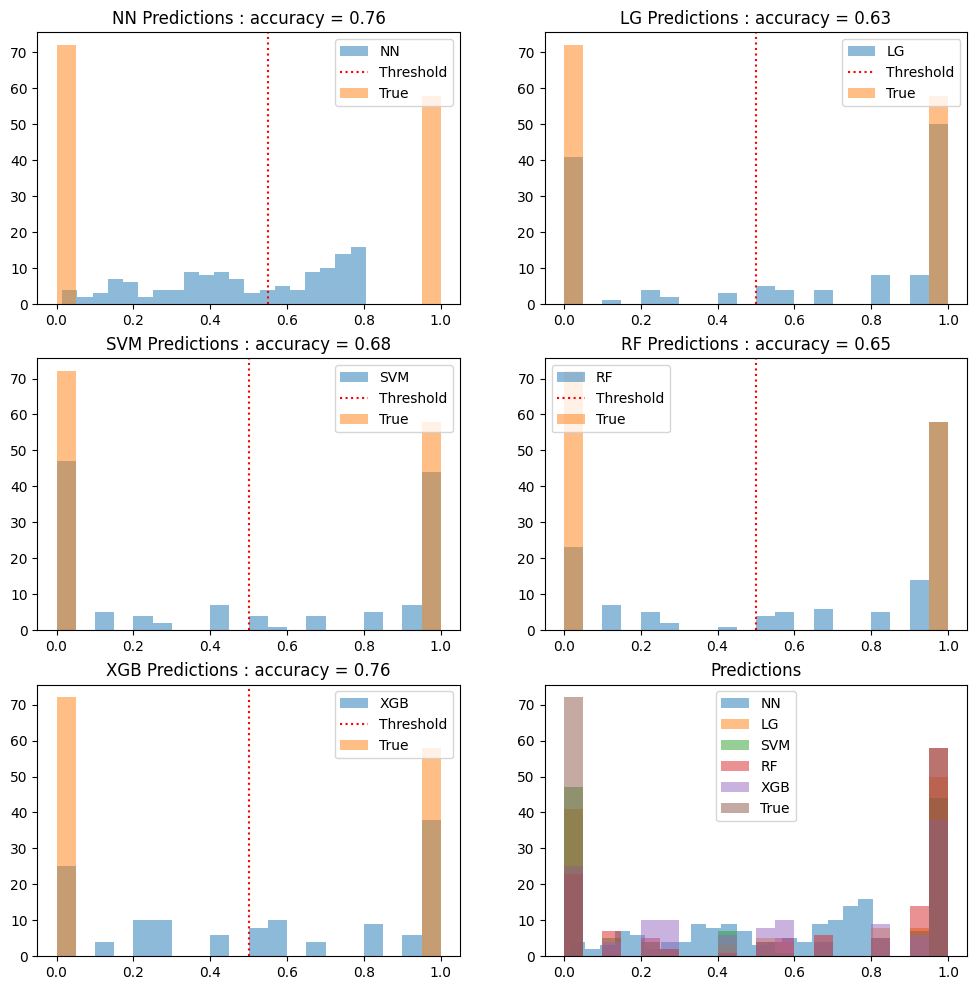

In [26]:
# Instead of passing eval_X, pass match3's tweets to the model
match3_tweets = match3['Tweet']
match3_X = tfidf_embedding(match3_tweets, vectorizer)
match3_loader = create_sets_for_eval(match3_X, scaler)

predictions_NN = []
model.eval()
with torch.no_grad():
    for batch in match3_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        predictions_NN.extend(outputs.cpu().numpy().flatten())

pridictions_lg = lg.predict(match3_X)
pridictions_svm = svm.predict(match3_X)
pridictions_rf = rf.predict(match3_X)
pridictions_xgb = xgb.predict(match3_X)

# Now predictions should align with match3 rows
predictions_match3 = pd.DataFrame({
    'ID': match3['ID'],
    'Predicted_NN': predictions_NN,
    'Predicted_LG': pridictions_lg,
    'Predicted_SVM': pridictions_svm,
    'Predicted_RF': pridictions_rf,
    'Predicted_XGB': pridictions_xgb,
    'MatchID': match3['MatchID'],
    'PeriodID': match3['PeriodID'],
    'EventType': match3['EventType']
})

# Group by ID/PeriodID/MatchID/EventType and average the predictions and sort by PeriodID
predictions_match3 = predictions_match3.groupby(['ID', 'PeriodID', 'MatchID', 'EventType']).mean().reset_index().sort_values('PeriodID')
predictions_match3['Predicted_NN_three'] = (predictions_match3['Predicted_NN'] > weight_1_0).astype(int)
predictions_match3['Predicted_LG_three'] = (predictions_match3['Predicted_LG'] > 0.5).astype(int)
predictions_match3['Predicted_SVM_three'] = (predictions_match3['Predicted_SVM'] > 0.5).astype(int)
predictions_match3['Predicted_RF_three'] = (predictions_match3['Predicted_RF'] > 0.5).astype(int)
predictions_match3['Predicted_XGB_three'] = (predictions_match3['Predicted_XGB'] > 0.5).astype(int)

# Accuracy if taking the majority vote between all models
print("Majority vote accuracy:", (predictions_match3[['Predicted_NN_three', 'Predicted_LG_three', 'Predicted_SVM_three', 'Predicted_RF_three', 'Predicted_XGB_three']].mode(axis=1)[0] == predictions_match3['EventType']).mean())

# Save the predictions
predictions_match3.to_csv('match3.csv', index=False)

# Compute the accuracies
print("NN Accuracy:", (predictions_match3['Predicted_NN_three'] == predictions_match3['EventType']).mean())
print("LG Accuracy:", (predictions_match3['Predicted_LG_three'] == predictions_match3['EventType']).mean())
print("SVM Accuracy:", (predictions_match3['Predicted_SVM_three'] == predictions_match3['EventType']).mean())
print("RF Accuracy:", (predictions_match3['Predicted_RF_three'] == predictions_match3['EventType']).mean())
print("XGB Accuracy:", (predictions_match3['Predicted_XGB_three'] == predictions_match3['EventType']).mean())

# Histogram of the predictions and the true values, with a dot-line at weight_1_0
# Each model's predictions are shown in a different subplot with the true values and the threshold

plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.hist(predictions_match3['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.axvline(weight_1_0, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'NN Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_NN_three"]):.2f}')

plt.subplot(3, 2, 2)
plt.hist(predictions_match3['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'LG Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_LG_three"]):.2f}')

plt.subplot(3, 2, 3)
plt.hist(predictions_match3['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'SVM Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_SVM_three"]):.2f}')

plt.subplot(3, 2, 4)
plt.hist(predictions_match3['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'RF Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_RF_three"]):.2f}')

plt.subplot(3, 2, 5)
plt.hist(predictions_match3['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'XGB Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_XGB_three"]):.2f}')

# #Last subplot with the three models' predictions
plt.subplot(3, 2, 6)
plt.hist(predictions_match3['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.hist(predictions_match3['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.hist(predictions_match3['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.hist(predictions_match3['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.hist(predictions_match3['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'Predictions')

plt.show()


Now Train the model on the whole dataset

In [49]:
# df_train = pd.read_csv("df_train_withoutstemming.csv")
# df_eval = pd.read_csv("df_eval_withoutstemming.csv")
df_train = pd.read_csv("df_train_tweets_with_lemmatization.csv")
df_eval = pd.read_csv("df_eval_tweets_with_lemmatization.csv")

df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

print(f'The shape of the training data is: {df_train.shape}')
print(f'The shape of the evaluation data is: {df_eval.shape}')

df_train = df_train.drop_duplicates()
df_eval = df_eval.drop_duplicates()

print(f'The shape of the training data after removing duplicates is: {df_train.shape}')
print(f'The shape of the evaluation data after removing duplicates is: {df_eval.shape}')

# Grouping
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

The shape of the training data is: (5056050, 6)
The shape of the evaluation data is: (1072928, 5)
The shape of the training data after removing duplicates is: (4515704, 6)
The shape of the evaluation data after removing duplicates is: (962928, 5)
Grouping tweets...
Tweets grouped in 1.61 seconds
--------------------------------------------------



In [ ]:
# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train_bis, test_size=0.01, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval['Tweet'], vectorizer)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

# Training
print("Training the model...")
t = time()

print(train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=epochs, weight_1_0=weight_1_0, scheduler=scheduler))

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Also test on different models (SVM, LG, RF, XGB)
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, kernel='linear')  # Smaller C increases regularization
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Logistic Regression
print("Testing on Logistic Regression with regularization:")
t = time()
lg = LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='liblinear')  # Stronger L2 regularization
lg.fit(train_X, train['EventType'])
print("Logistic Regression Accuracy:", lg.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Random Forest
print("Testing on Random Forest with regularization:")
t = time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3)  # Depth/leaf regularization
rf.fit(train_X, train['EventType'])
print("Random Forest Accuracy:", rf.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized XGBoost
print("Testing on XGBoost with regularization:")
t = time()
xgb = XGBClassifier(eval_metric='logloss', reg_alpha=1, reg_lambda=1, max_depth=6, learning_rate=0.05, n_estimators=200)
xgb.fit(train_X, train['EventType'])
print("XGBoost Accuracy:", xgb.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------

Embedding...
Data embedded in 24.11 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.33 seconds
--------------------------------------------------

Training the model...
Epoch 1/20, Train Loss: 0.8082, Val Loss: 0.6949, Val Accuracy: 0.5234
Epoch 2/20, Train Loss: 0.7012, Val Loss: 0.6963, Val Accuracy: 0.5607
Epoch 3/20, Train Loss: 0.6979, Val Loss: 0.7003, Val Accuracy: 0.5561
Epoch 4/20, Train Loss: 0.6958, Val Loss: 0.6936, Val Accuracy: 0.6028
Epoch 5/20, Train Loss: 0.6886, Val Loss: 0.6957, Val Accuracy: 0.5748
Epoch 6/20, Train Loss: 0.6828, Val Loss: 0.6877, Val Accuracy: 0.5701
Epoch 7/20, Train Loss: 0.6720, Val Loss: 0.6740, Val Accuracy: 0.5935
Epoch 8/20, Train Loss: 0.6568, Val Loss: 0.6422, Val Accuracy: 0.6542
Epoch 9/20, Train Loss: 0.6360, Val Loss: 0.6134, Val Accuracy: 0.6963
Epoch 10/20, Train Loss: 0.6225, 

Predictions saved to 'evaluation_predictions.csv' and individual model files.
--------------------------------------------------



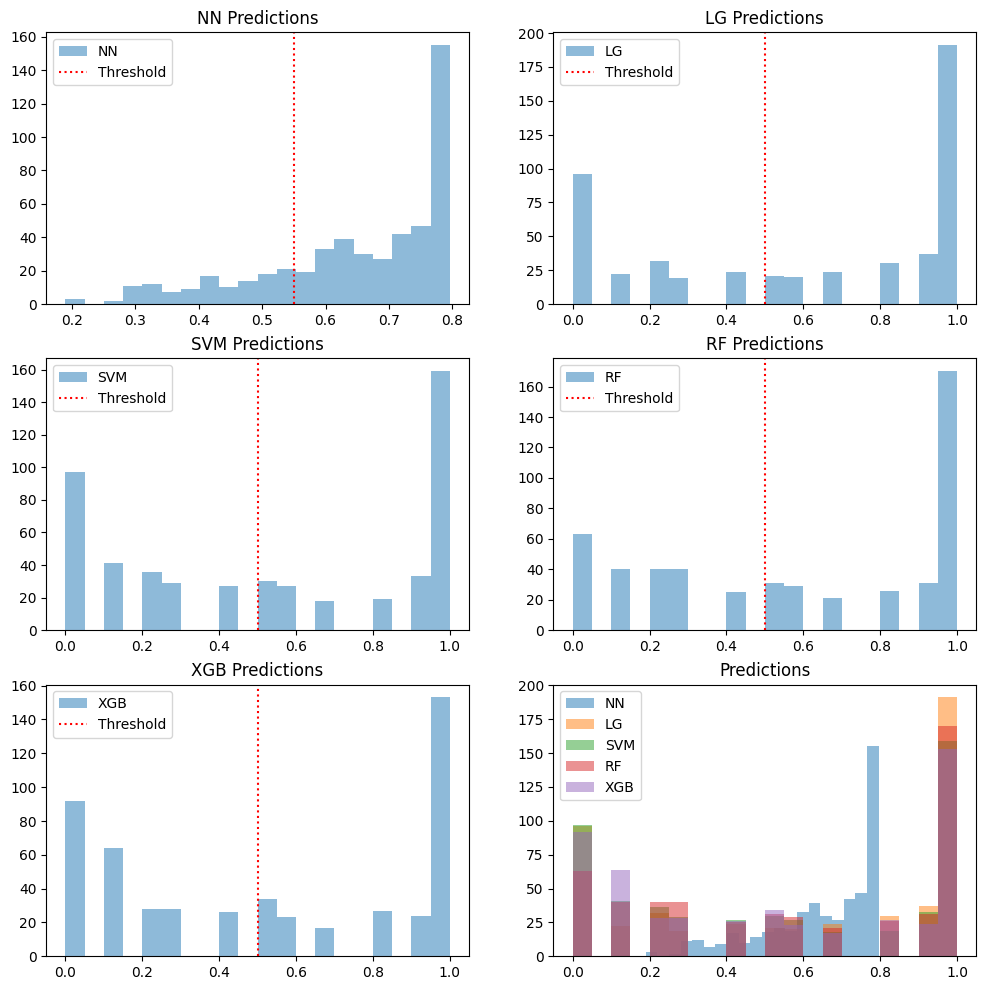

In [ ]:
# Instead of passing eval_X, pass match3's tweets to the model
eval_tweets = df_eval_bis['Tweet']
eval_X = tfidf_embedding(eval_tweets, vectorizer)
# eval_X = glove_embedding(eval_tweets, embeddings, embedding_dim=embedding_dim)
# eval_X = word2vec_embedding([t.split() for t in eval_tweets], model_w2v)
eval_loader = create_sets_for_eval(eval_X, scaler)

predictions_NN = []
model.eval()
with torch.no_grad():
    for batch in eval_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        predictions_NN.extend(outputs.cpu().numpy().flatten())

pridictions_lg = lg.predict(eval_X)
pridictions_svm = svm.predict(eval_X)
pridictions_rf = rf.predict(eval_X)
pridictions_xgb = xgb.predict(eval_X)

# Now predictions should align with match3 rows
predictions_eval = pd.DataFrame({
    'ID': df_eval_bis['ID'],
    'MatchID': df_eval_bis['MatchID'],
    'PeriodID': df_eval_bis['PeriodID'],
    'Predicted_NN': predictions_NN,
    'Predicted_LG': pridictions_lg,
    'Predicted_SVM': pridictions_svm,
    'Predicted_RF': pridictions_rf,
    'Predicted_XGB': pridictions_xgb
})


# Group by ID/PeriodID/MatchID and average the predictions and sort by matchID and then PeriodID
predictions_eval = predictions_eval.groupby(['ID', 'MatchID', 'PeriodID']).mean().reset_index().sort_values(['MatchID', 'PeriodID'])
predictions_eval['Predicted_NN_three'] = (predictions_eval['Predicted_NN'] > weight_1_0).astype(int)
predictions_eval['Predicted_LG_three'] = (predictions_eval['Predicted_LG'] > 0.5).astype(int)
predictions_eval['Predicted_SVM_three'] = (predictions_eval['Predicted_SVM'] > 0.5).astype(int)
predictions_eval['Predicted_RF_three'] = (predictions_eval['Predicted_RF'] > 0.5).astype(int)
predictions_eval['Predicted_XGB_three'] = (predictions_eval['Predicted_XGB'] > 0.5).astype(int)

# Histogram of the predictions and the true values as before 
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.hist(predictions_eval['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.axvline(weight_1_0, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'NN Predictions')

plt.subplot(3, 2, 2)
plt.hist(predictions_eval['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'LG Predictions')

plt.subplot(3, 2, 3)
plt.hist(predictions_eval['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'SVM Predictions')

plt.subplot(3, 2, 4)
plt.hist(predictions_eval['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'RF Predictions')

plt.subplot(3, 2, 5)
plt.hist(predictions_eval['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'XGB Predictions')

# Last subplot with the three models' predictions
plt.subplot(3, 2, 6)
plt.hist(predictions_eval['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.hist(predictions_eval['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.hist(predictions_eval['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.hist(predictions_eval['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.hist(predictions_eval['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.legend()
plt.title(f'Predictions')

# Save the predictions
predictions_eval.to_csv('evaluation_predictions.csv', index=False)

# Save individual predictions for each model
predictions_eval[['ID', 'Predicted_NN_three']].to_csv('evaluation_predictions_NN__basic.csv', index=False)
predictions_eval[['ID', 'Predicted_LG_three']].to_csv('evaluation_predictions_LG__basic.csv', index=False)
predictions_eval[['ID', 'Predicted_SVM_three']].to_csv('evaluation_predictions_SVM__basic.csv', index=False)
predictions_eval[['ID', 'Predicted_RF_three']].to_csv('evaluation_predictions_RF__basic.csv', index=False)
predictions_eval[['ID', 'Predicted_XGB_three']].to_csv('evaluation_predictions_XGB__basic.csv', index=False)

print("Predictions saved to 'evaluation_predictions.csv' and individual model files.")
print("-" * 50 + "\n")
